In [1]:
!pip install shapely

In [3]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 2.4 MB/s eta 0:00:0000:0100:01


In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from scipy.cluster.hierarchy import linkage, dendrogram


from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim


from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [5]:
# Setting the default size of visualisations.
sns.set(rc={'figure.figsize': (9, 6)})

# Ignoring red warnings
pd.options.mode.chained_assignment = None

# Colour for barplots (and yeah, British spelling is quite useful in this case)
colour = '#748881'

In [8]:
def make_basic_overview(data):
    '''
    Make basic overview for the pandas DataFrame (see inner structure).
    
    Args:
        data (DataFrame): The DataFrame to work with.
        
    Returns:
        nothing
    '''
    
    border = 12*'='
    
    print(border, 'Basic Info', border)
    data.info()
    print('\n\n')
    
    print(border, 'First Five Rows', border)
    display(data.head())
    print('\n\n')
    
    print(border, 'Last Five Rows', border)
    display(data.tail())
    print('\n\n')
    
    print(border, 'Duplicates', border)
    print()
    if data.duplicated().sum() > 0:
        print(f'Amount of duplicated rows: {data.duplicated().sum()}.')
        data.drop_duplicates(inplace=True, ignore_index=True)
        print('Duplicated rows were dropped.')
    else:
        print('None.')
        
        
def numeric_cols_hist(data, width, height):
    '''
    Plot histograms for all columns with numeric values.
    
    Args:
        data (DataFrame): The DataFrame to work with.
        width (int): The width of the resulting tile-looking visualisation.
        height (int): The width of the resulting tile-looking visualisation.
    
    Returns:
        Nothing.
        
    '''
    cols = data.select_dtypes(include=('number')).columns.to_list()
    data[cols].hist(bins=30, figsize=(width, height))
    plt.show()
    print('Here, the density of values in each numeric column is shown.')


def make_df_dtype(data):
    '''
    Makes a dataframe to overview data of the original dataframe, column by column.
    Each resulting row provides info dealing with each column:
    - data type
    - data specimen
    - number of unique values
    - share of missing values
    
    Args:
        data (DataFrame): The DataFrame to work with.
        
    Returns:
        resulting DataFrame        
    '''
    
    cols, dtype_col, specimens, nunique, null_share = [], [], [], [], []
    for column in data:
        cols.append(column)
        
        this_dtype = data[column].dtype
        dtype_col.append(this_dtype)
        
        specimen = data.loc[data[column].first_valid_index(), column]
        specimens.append(specimen)
        
        nunique.append(data[column].nunique())
        
        null_sum = data[column].isna().sum()
        null_to_len = null_sum / len(data[column])
        null_share.append(f'{null_to_len:.2%}')
        
    df = pd.DataFrame(list(zip(dtype_col,
                               specimens,
                               nunique,
                              null_share)),
                      index=cols)    
    df.columns=['dtype',
                'specimen',
                'nunique',
               'null_share']
 
    return df



def make_heatmap_cities_per_countries_and_categories(
    list_of_countries,
    category_column,
    ylabel,
    xlabel,
    plttitle,
    palette
):
    '''
    Make heatmap based on the crosstab:
        1) create a df with selected countries only
        2) make a crosstab there:
            index = df.country (i.e. list of countries)
            columns = df.category (i.e. unique categories)
            values = df.city
            aggfunc = count
        3) visualise it as a heatmap (with all of the extra details).
    
    Args:
        list_of_countries_lst (list): list of countries to work with.
        category_column_str (str):
            pollutant categorical column ('aqi_category').
        ylabel_str (str):
            country list descriprion for Y axis label,
            for instance: 'top 10 well-represented countries\nwithin the dataset\n'
        xlabel_str (str): pollutant for X axis label ('\nair quality index (AQI)\n').
        plttitle_str (str): visualisation title.
        palette (str): colourmap ('viridis' etc.)
    
    Returns:
        Nothing.
    
    '''
    # Make a dataframe with countries selected.
    df = data.query('country in @list_of_countries')
    
    
    # Enumerate categories to bring some order into visualisations.
    # Work with this temporary dataset, the original one is unchanged.
    
    # str_cols_list is created in the beginning of the project
    # (non-numeric colums excluding cities and countries).
    for column in str_cols_list:
        i = 0
        for item in ['Good', 'Moderate', 'Unhealthy for Sensitive Groups',
                     'Unhealthy', 'Very Unhealthy', 'Hazardous']:
            i+=1
            df.loc[df[column] == item, column] = f'{i}. {item}'
    
    
    fig, ax = plt.subplots()
    
    # The heatmap is based on this crosstab.
    this_crosstab = pd.crosstab(
        # Count the cities per each country and category.
        index=df.country,
        columns=df[category_column],
        values=df['city'],
        aggfunc='count',

        # Normalize by dividing all values by the sum of values
        # (over each column).
        normalize='index'
    )
    
    
    # Make a heatmap.
    sns.heatmap(
        this_crosstab
        # Sort values of the crosstab by the first column.
        .sort_values(by='1. Good', ascending=False),

        # Start of the heatmap's code.
        # Palette.
        cmap=palette,
        # Annotations.
        annot=True,
        fmt='.2%',
        # Edges.
        linecolor='#959595',
        linewidths=.75,
        # Colorbar is redundant.
        cbar=False
    )

    # Y
    plt.ylabel(ylabel)

    # X
    plt.xlabel(xlabel)
    plt.xticks(ticks = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
               labels=['Good', 'Moderate', 'Unhealthy\nfor Sensitive\nGroups',
                     'Unhealthy', 'Very\nUnhealthy', 'Hazardous'],
              rotation=360,
               ha='center')

    # Title.
    ax.set_title(plttitle,
              fontsize=25,
              loc='left')
    
    # Describe how to show nans.
    ax.patch.set(hatch='xx', edgecolor='lightgrey')
    
    # Show visualisation.
    plt.show()
    
    # This code meant to print extra comment if there are any nans.
    # Doesn't work for now.
    # if this_crosstab.isna().values.any() > 0:
        # print('    Lightgrey: no entries listed.\n')

    
    
# We will use this list of lists very often.
# Three 'courses' per turn, or 'option'.
# option[0] will be used for columns,
# option[1] - for titles/labels and so on,
# option[2] - extended comment.
column_description = [
    ['aqi', 'air quality index (AQI)', 'Air quality index (AQI): shows how polluted the air currently is\nor how polluted it is forecast to become.'],
    ['co_aqi', 'carbon monoxide (CO)', 'Carbon Monoxide is a colorless and odorless gas.\nOutdoor, it is emitted in the air above all by cars,\ntrucks and other vehicles or machineries that burn fossil fuels.'],
    ['ozone_aqi', 'ozone (O3)', 'Ground level ozone can provoke several health problems like chest pain,\ncoughing, throat irritation and airway inflammation.'],
    ['no2_aqi', 'nitrogen dioxide (NO2)', 'At the surface level, NO2 forms from cars, trucks and buses emissions,\npower plants and off-road equipment.\nExposures may contribute to develoment of asthma and respiratory infections.'],
    ['pm2_5_aqi', 'atmospheric particulate matter (PM2.5)', 'Atmospheric Particulate Matter, also known as atmospheric aerosol particles,\nare complex mixtures of small solid and liquid matter that get into the air.\nIf inhaled they can cause serious heart and lungs problem.']
              ]

In [6]:
data = pd.read_csv('global_air_pollution.csv')

# Data Overview

## Description

Air quality index (AQI)

An air quality index (AQI) is used to communicate to the public how polluted the air currently is or how polluted it is forecast to become.


This dataset also provides geolocated information about the following pollutants:

Nitrogen Dioxide [NO2]

Nitrogen Dioxide is one of the several nitrogen oxides. It is introduced into the air by natural phenomena like entry from stratosphere or lighting. At the surface level, however, NO2 forms from cars, trucks and buses emissions, power plants and off-road equipment. Exposure over short periods can aggravate respiratory diseases, like asthma. Longer exposures may contribute to develoment of asthma and respiratory infections. People with asthma, children and the elderly are at greater risk for the health effects of NO2.


Ozone [O3]

The Ozone molecule is harmful for outdoor air quality (if outside of the ozone layer). At surface level, ozone is created by chemical reactions between oxides of nitrogen and volatile organic compounds (VOC). Differently from the good ozone located in the upper atmosphere, ground level ozone can provoke several health problems like chest pain, coughing, throat irritation and airway inflammation. Furthermore it can reduce lung function and worsen bronchitis, emphysema, and asthma. Ozone affects also vegetation and ecosystems. In particular, it damages sensitive vegetation during the growing season.

Carbon Monoxide [CO]

Carbon Monoxide is a colorless and odorless gas. Outdoor, it is emitted in the air above all by cars, trucks and other vehicles or machineries that burn fossil fuels. Such items like kerosene and gas space heaters, gas stoves also release CO affecting indoor air quality. Breathing air with a high concentration of CO reduces the amount of oxygen that can be transported in the blood stream to critical organs like the heart and brain. At very high levels, which are not likely to occur outdoor but which are possible in enclosed environments. CO can cause dizziness, confusion, unconsciousness and death.

Particulate Matter [PM2.5]

Atmospheric Particulate Matter, also known as atmospheric aerosol particles, are complex mixtures of small solid and liquid matter that get into the air. If inhaled they can cause serious heart and lungs problem. They have been classified as group 1 carcinogen by the International Agengy for Research on Cancer (IARC). PM10 refers to those particules with a diameter of 10 micrometers or less. PM2.5 refers to those particles with a diameter of 2.5 micrometers or less.

In [9]:
make_df_dtype(data)

,dtype,specimen,nunique,null_share
Country,object,Russian Federation,175,1.82%
City,object,Praskoveya,23462,0.00%
AQI Value,int64,51,347,0.00%
AQI Category,object,Moderate,6,0.00%
CO AQI Value,int64,1,34,0.00%
CO AQI Category,object,Good,3,0.00%
Ozone AQI Value,int64,36,213,0.00%
Ozone AQI Category,object,Good,5,0.00%
NO2 AQI Value,int64,0,59,0.00%
NO2 AQI Category,object,Good,2,0.00%


In [10]:
make_basic_overview(data)

============ Basic Info ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23036 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23463 non-null  int64 
 3   AQI Category        23463 non-null  object
 4   CO AQI Value        23463 non-null  int64 
 5   CO AQI Category     23463 non-null  object
 6   Ozone AQI Value     23463 non-null  int64 
 7   Ozone AQI Category  23463 non-null  object
 8   NO2 AQI Value       23463 non-null  int64 
 9   NO2 AQI Category    23463 non-null  object
 10  PM2.5 AQI Value     23463 non-null  int64 
 11  PM2.5 AQI Category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB



============ First Five Rows ============


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good





============ Last Five Rows ============


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
23458,India,Gursahaiganj,184,Unhealthy,3,Good,154,Unhealthy,2,Good,184,Unhealthy
23459,France,Sceaux,50,Good,1,Good,20,Good,5,Good,50,Good
23460,India,Mormugao,50,Good,1,Good,22,Good,1,Good,50,Good
23461,United States of America,Westerville,71,Moderate,1,Good,44,Good,2,Good,71,Moderate
23462,Malaysia,Marang,70,Moderate,1,Good,38,Good,0,Good,70,Moderate





============ Duplicates ============

None.


In [11]:
data.columns = (
    data
    .columns
    .str.lower()
    .str.replace(' ', '_', regex=False)
    .str.replace('.', '_', regex=False)
)

data.columns

Index(['country', 'city', 'aqi_value', 'aqi_category', 'co_aqi_value',
       'co_aqi_category', 'ozone_aqi_value', 'ozone_aqi_category',
       'no2_aqi_value', 'no2_aqi_category', 'pm2_5_aqi_value',
       'pm2_5_aqi_category'],
      dtype='object')

In [12]:
# Make a dictionary to store the columns' groups.
data_dict = dict()

# Divide columns into numeric and non-numeric ones.
num_cols_list = data.select_dtypes(include='number').columns.to_list()
str_cols_list = data.select_dtypes(include='object').columns.to_list()

# Remove cities and countries from the list: they will be used differently.
str_cols_list.remove('country')
str_cols_list.remove('city')

# Save lists into the dictionary.
data_dict['str_cols_list'] = str_cols_list
data_dict['num_cols_list'] = num_cols_list

# Check the result.
print('Non-numeric values:')
display(data_dict['str_cols_list'])
print('\nNumeric values:')
display(data_dict['num_cols_list'])

Non-numeric values:


['aqi_category',
 'co_aqi_category',
 'ozone_aqi_category',
 'no2_aqi_category',
 'pm2_5_aqi_category']


Numeric values:


['aqi_value',
 'co_aqi_value',
 'ozone_aqi_value',
 'no2_aqi_value',
 'pm2_5_aqi_value']

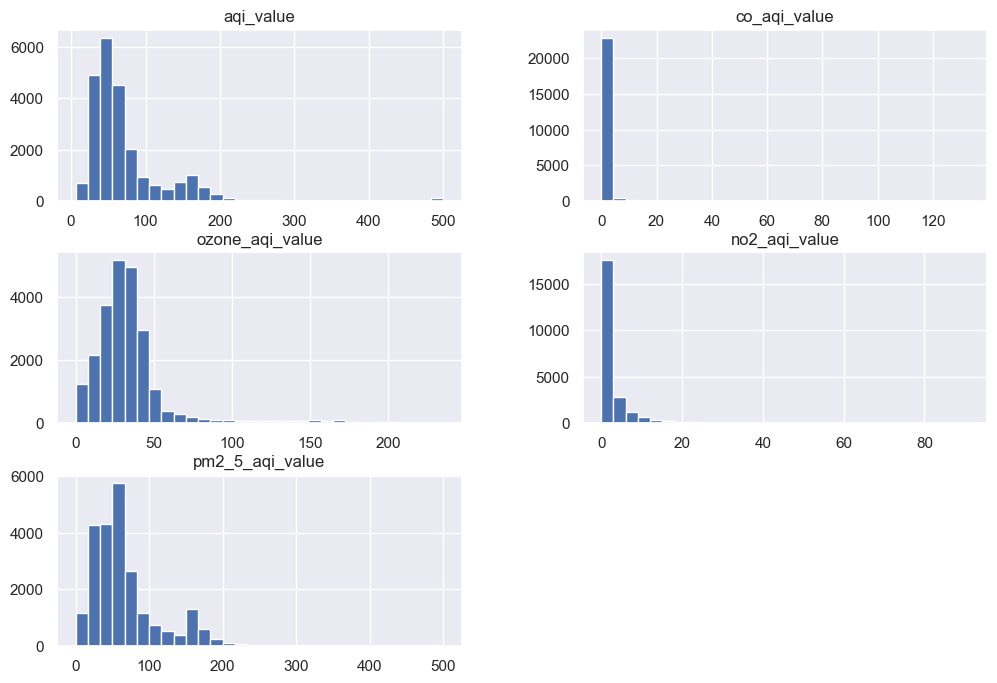

Here, the density of values in each numeric column is shown.


In [13]:
numeric_cols_hist(data, width=12, height=8)

Missing values can be found only in Country column (about 1.82%).

In [15]:
missing_country_cities = data.loc[data.country.isna()]['city'].unique()
print(f"We've got {len(missing_country_cities)} cities without a stated country.")
print('For instance:')
for city in missing_country_cities[:15]:
    print(f'- {city}')

We've got 427 cities without a stated country.
For instance:
- Granville
- Kingston Upon Hull
- New Waterford
- Kingstown
- Nanakuli
- Lavagna
- Ladispoli
- Dong Hoi
- Nettuno
- Puebloviejo
- Fiumicino
- Nishinomiya
- Carteret
- Ercolano
- Bolama


In [16]:
# Check is there already an 'Unknown' country.
try:
    data.loc[data['country' == 'Unknown']]
except KeyError:
    print('None')
    

# Fill the nans.
data['country'] = data['country'].fillna('Unknown')
print(f"Missing values: {data['country'].isna().sum()}")

None
Missing values: 0


In [17]:
# Overview the numbers of entries per country.
(
    data
    .groupby('country')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Show the statistics.
    .describe()
)

count     176.000000
mean      133.312500
std       355.508745
min         1.000000
25%        10.750000
50%        28.500000
75%        81.000000
max      2872.000000
Name: aqi_category, dtype: float64

Almost half of the countries within this dataset are mentioned in 30 entries or less than that.

Three-quarters are mentioned in 80 rows or less than that.

There is at least one country that has almost 3000 rows.

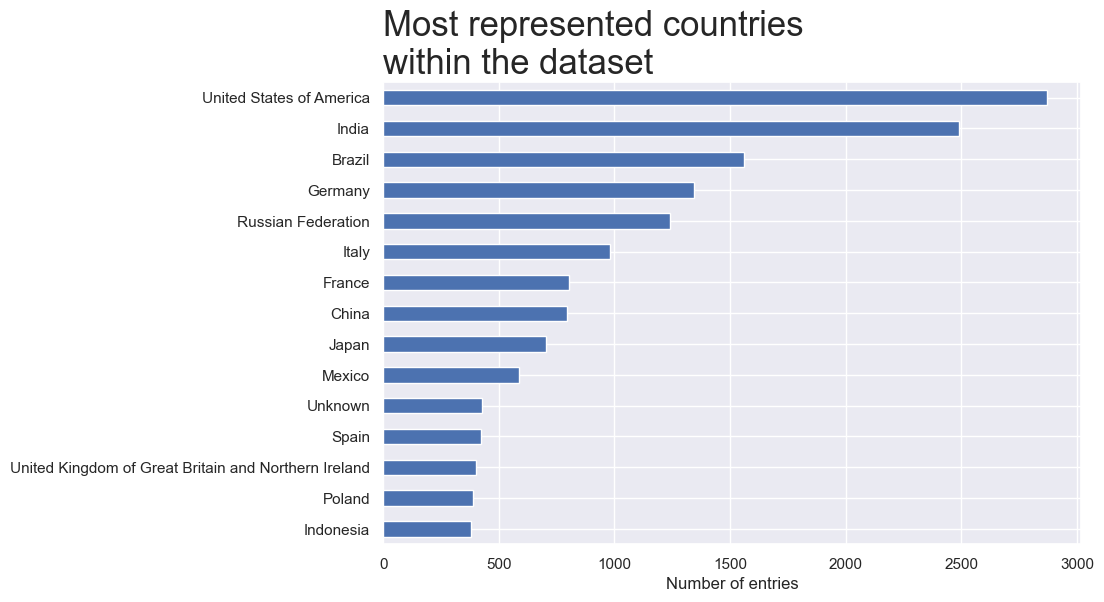

In [18]:
(
    data
    .groupby('country')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Sort values.
    .sort_values(ascending=False)
    # Extract the first 15.
    .head(15)
    # Sort values to have the commonest option at the top.
    .sort_values(ascending=True)
    # Plot the top 15.
    .plot(kind='barh')
)
plt.title('Most represented countries\nwithin the dataset', loc='left', fontsize=25)
# Remove the label for axis Y.
plt.ylabel('')
plt.xlabel('Number of entries')
plt.show()

Unknown country, which is thought to correspond to less than 2%, is listed in the top 15 represented entities.

In [19]:
data = data.loc[data.country != 'Unknown']

In [20]:
total_letters = 15
print(f'Countries that have more than {total_letters} letters in their name:')
for country in data.country.unique():
    if len(country) > total_letters:
        print(f"\t- '{country}'")

Countries that have more than 15 letters in their name:
	- 'Russian Federation'
	- 'United States of America'
	- 'Republic of North Macedonia'
	- 'United Kingdom of Great Britain and Northern Ireland'
	- 'United Republic of Tanzania'
	- 'Iran (Islamic Republic of)'
	- 'Democratic Republic of the Congo'
	- 'Papua New Guinea'
	- 'Bosnia and Herzegovina'
	- 'Dominican Republic'
	- 'Bolivia (Plurinational State of)'
	- 'Venezuela (Bolivarian Republic of)'
	- 'Republic of Moldova'
	- 'Kingdom of Eswatini'
	- 'Central African Republic'
	- 'Republic of Korea'
	- 'United Arab Emirates'
	- 'Syrian Arab Republic'
	- 'Lao People's Democratic Republic'
	- 'Trinidad and Tobago'
	- 'Equatorial Guinea'
	- 'State of Palestine'
	- 'Saint Kitts and Nevis'


In [21]:
for pair in [
    ['Republic of North Macedonia', 'North Macedonia'],
    ['Iran (Islamic Republic of)', 'Iran'],
    ['Bolivia (Plurinational State of)', 'Bolivia'],
    ['Venezuela (Bolivarian Republic of)', 'Venezuela'],
    ['United Arab Emirates', 'UAE'],
    ['Syrian Arab Republic', 'Syria'],
    ['Russian Federation', 'Russia'],
    ['United Kingdom of Great Britain and Northern Ireland', 'UK'],
    ['United States of America', 'USA'],
    ['State of Palestine', 'Palestine'],
    ['Central African Republic', 'CAR'],
    ['Republic of Korea', 'South Korea'],
    ['Democratic Republic of the Congo', 'DRC'],
    ['Laos', "Lao People's Democratic Republic"],
    ['Kingdom of Eswatini', 'Eswatini'],
    ['United Republic of Tanzania', 'Tanzania']
]:
    
    # regex=False to avoid a red warning
    data['country'] = data['country'].replace(pair[0], pair[1], regex=False)

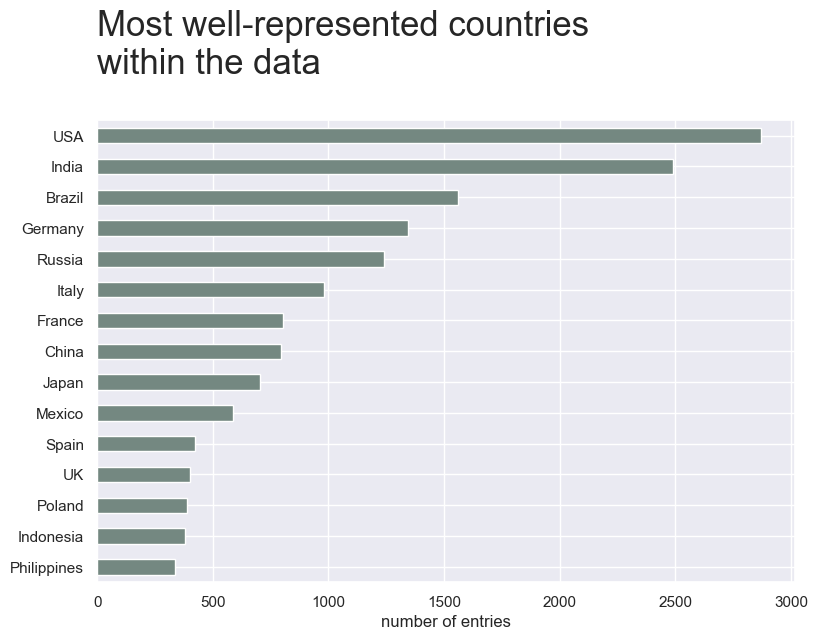

In [22]:
(
    data
    .groupby('country')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Sort values.
    .sort_values(ascending=False)
    # Extract the first 15.
    .head(15)
    # Sort values to have the commonest option at the top.
    .sort_values(ascending=True)
    # Plot the top 15.
    .plot(kind='barh', color=colour)
)
plt.title('Most well-represented countries\nwithin the data\n', loc='left', fontsize=25)
# Remove the label for axis Y.
plt.ylabel('')
plt.xlabel('number of entries')
plt.show()

In [23]:
# Overview the numbers of entries per city.
(
    data
    .groupby('city')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Show the statistics.
    .describe()
)

count    23035.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: aqi_category, dtype: float64

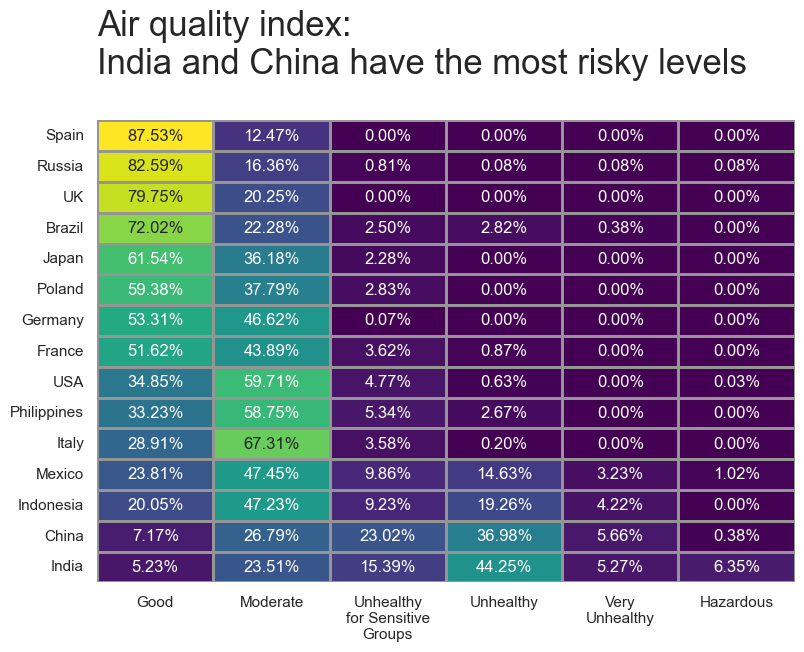

In [24]:
# Make a list of countries.
top_list = (data.groupby('country')
               # Count the rows: any column without missing values
               ['aqi_category'].count()
               # Sort values.
               .sort_values(ascending=False)
               .head(15)
               .index
               .to_list())


# See function defined in the beginning of this notebook.
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='aqi_category',
    ylabel='',
    xlabel='',
    plttitle="Air quality index:\nIndia and China have the most risky levels\n",
    palette='viridis'
)

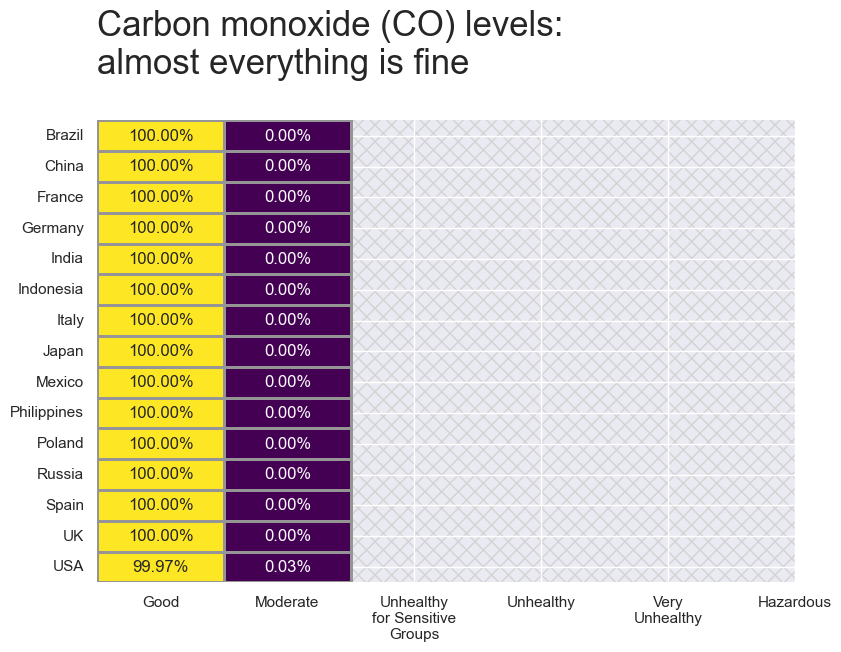

In [25]:
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='co_aqi_category',
    ylabel='',
    xlabel='',
    plttitle="Carbon monoxide (CO) levels:\nalmost everything is fine\n",
    palette='viridis'
)

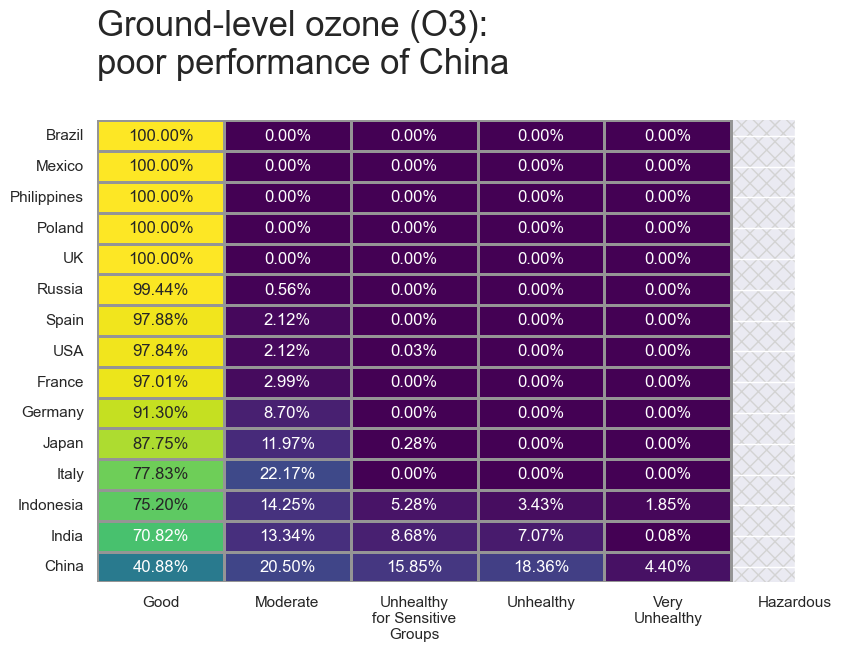

In [26]:
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='ozone_aqi_category',
    ylabel='',
    xlabel='',
    plttitle='Ground-level ozone (O3):\npoor performance of China\n',
    palette='viridis'
)

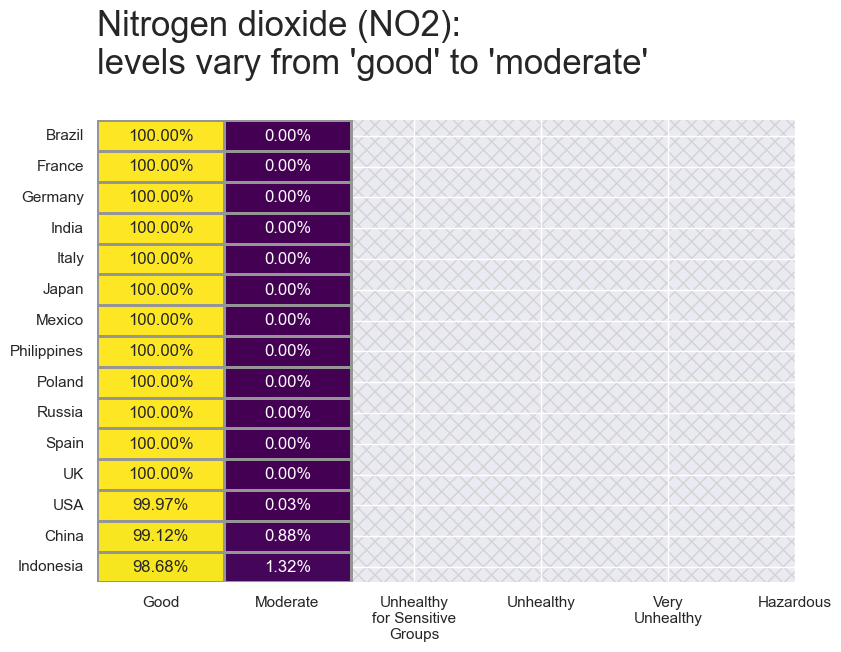

In [27]:
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='no2_aqi_category',
    ylabel='',
    xlabel='',
    plttitle="Nitrogen dioxide (NO2):\nlevels vary from 'good' to 'moderate'\n",
    palette='viridis'
)

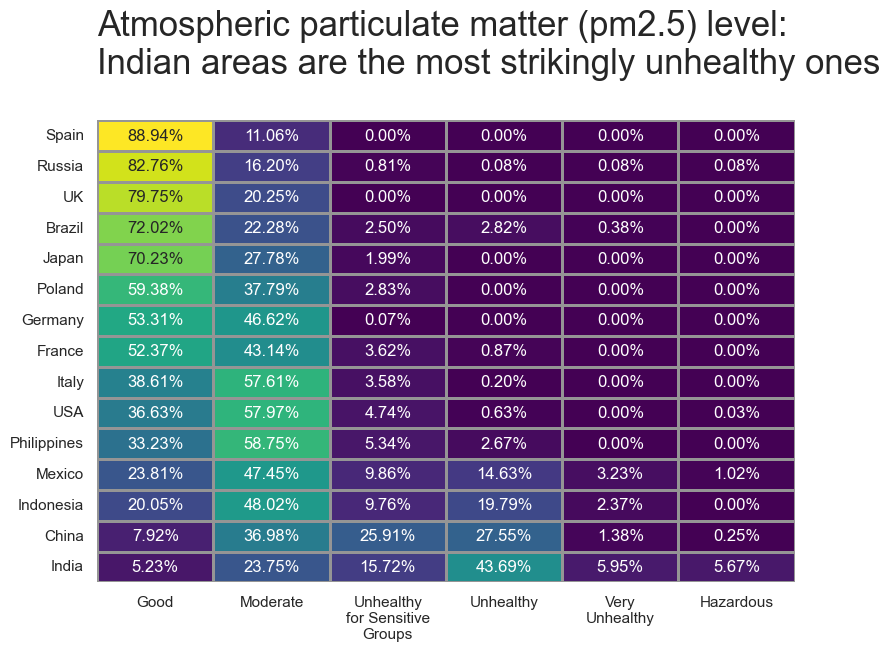

In [28]:
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='pm2_5_aqi_category',
    ylabel='',
    xlabel='',
    plttitle="Atmospheric particulate matter (pm2.5) level:\nIndian areas are the most strikingly unhealthy ones\n",
    palette='viridis'
)

# Observations

## Air quality index

These countries have a significant percentage of locations labelled 'Unhealthy for Sensitive Groups' or 'Unhealthy':

India (15.4% and 44.2% respectively)
China (23% and 37% respectively)
In India, a significant percentage of locations are marked with the worst category, 'Dangerous' (6.3%). At the same time, less than one-third of Indian locations were considered as having a 'Good' or 'Moderate' air quality index: everything else is below the line of healthy conditions.

Having about 5-7% of 'good' locations, India and China are strikingly different from the rest of the countries. Indonesia and Mexico, countries that precede them in the rating of air quality index, have over 20-23% of 'good' locations.

The best air quality index, from 'Good' to 'Moderate', can be found in Spain. Unlike the others, this country seems to have no locations listed under more risky categories. 

## Carbon monoxide (CO)

No country has her locations marked as belonging to one of the risky categories. It is possible that only the 'Good' to 'Moderate' scale is used for measurements.

With a 'Good' performance in all 15 countries, only the USA has a minor percentage of 'Moderate' locations.

## Ground-level ozone

There is no data on 'hazardous' places.

China demonstrated the worst conditions: less than 40% of locations here are labelled 'Unhealthy for Sensitive Groups' to 'Very Unhealthy'. At the same time, more than 61% of areas were described as within normal limits ('Good' to 'Normal'), so the situation is not so dramatic if compared to the Indian air quality index.

Speaking of India, within this category, over 70% of the locations are considered to have 'good' conditions.

The absolute leaders regarding their ground-level ozone category - all 100% 'Good' - are five countries:

Brazil
Mexico
Philippines
Poland
UK.

## Nitrogen dioxide

Just like in the case of Carbon Monoxide, the two-part scale - from 'Good' to 'Moderate' - is presented.

Relatively worse conditions can be found in:

Indonesia (1.3% of areas are labelled as 'Moderate')
China (0.9%)
A really minor percentage of 'Moderate' areas can be found in the USA (0.3%).

## Atmospheric particulate matter (pm2.5)

A picture has some resemblance to that of the air quality index categories.

Similar to the air quality index, the worst conditions can be found in India, China, Indonesia and Mexico.

The divide between India and China (about 5-8% of 'Good' areas) and Indonesia and Mexico (20-24%) remains almost the same in comparison to the air quality index.

Once again, less than one-third of Indian locations are labelled 'Good' to 'Moderate' with about 44% being considered 'Unhealthy'.

## Observations dealing with visualisations: the importance of colour scheme

Just like in the case of visualisations, there is no 'good' or 'bad' palette. Okay, there is, but in fact, each of them is either working or not.

A good visualisation helps to grasp overall trends while leaving some chances to explore more specific details in depth.

Visualisations can't show what isn't present in a dataset. At the same time, they can highlight or hide (quite possibly, erroneously) some details.

The only difference between the heatmaps below is the palette used. I am still thinking that 'viridis' is the best choice:

Even though sometimes a monochrome palette can be beneficial, in this case, 'viridis' is colourful enough to attract attention, but it's not redirecting it to itself: there's no resemblance to an abstract painting (in my opinion).
With its transition from warmish yellows through greens to coldish violets, it emphasises the contrast between 80-90% and 0-10% perfectly. With values being specifically sorted 'under the hood' of the visualisation, it helps to grasp the pattern of gradual accumulation of 'risky' air pollution categories (yeah, we have to put some extra effort to make the data less chaotic).
At the same time, this colourmap is not washing away completely the contrast between 5% and 0% (the task that many other colourmaps have failed). The hues representing 5% and 0% are subtle (and, thus, not perfectly user-friendly in this rendition), yet still different.